### non iid

### 准备各个用户数据（第i个用户拥有4000个i标签的数据，及300个其它标签的数据，共计6700个样本数据）

In [10]:
# 挂载谷歌云盘
from google.colab import drive
drive.mount("/content/drive")

# 准备各个用户数据
import pandas as pd

good_user_number=10



all_user_data=[]
all_user_label=[]
all_user_validate_data=[]
all_user_validate_label=[]

for i in range(good_user_number):
  all_user_data.append(pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/u"+str(i)+"/data.csv",index_col=0).values)
  all_user_label.append(pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/u"+str(i)+"/label.csv",index_col=0).values)
  all_user_validate_data.append(pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/u"+str(i)+"/validate_data.csv",index_col=0).values)
  all_user_validate_label.append(pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/u"+str(i)+"/validate_label.csv",index_col=0).values)

requester_data=pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/requester/data.csv",index_col=0).values
requester_label=pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/requester/label.csv",index_col=0).values

validate_data=pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/validate/data.csv",index_col=0).values
validate_label=pd.read_csv("/content/drive/MyDrive/EE_blockchain/non_iid/validate/label.csv",index_col=0).values

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 定义函数

In [24]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
tf.reset_default_graph()
tf.set_random_seed(2)

class FL:
    def __init__(self,name,sess,data=None,label=None,validate_data=None,validate_label=None,isCommittee=False,isBad=False,lr=0.0005):
        self.lr=lr    #LEARNING_RATE
        self.sess=sess
        self.name=name
        self.c_name=self.name+"params"
        self.parameters=self.build_net(self.c_name)
        self.data=data
        self.label=label
        self.validate_data=validate_data
        self.validate_label=validate_label
        self.isCommittee=isCommittee
        self.isBad=isBad
        
        
        
    def build_net(self,c_name):
        CONV_SIZE = 3
        CONV_1_KERNAL = 32 
        CONV_2_KERNAL = 64
        
        W_INITIALIZER=tf.truncated_normal_initializer(0,0.05)
        B_INITIALIZER=tf.constant_initializer(0.03)

                    
        # 卷积神经网络
        def params(name,shape,initializer,c_names):
            return tf.get_variable(name,shape,initializer=initializer,collections=c_names)
        
        def conv2d(x,w):
            return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding="SAME")
        
        def pool(x):
            return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
        
        self.x=tf.placeholder(tf.float32,[None,784],name="input_features")
        self.y=tf.placeholder(tf.float32,[None,10],name="actual_labels")
        self.keep_prob=tf.placeholder(tf.float32,name="keep_prob")
        image_x=tf.reshape(self.x,[-1,28,28,1])
        
        c_names=[tf.GraphKeys.GLOBAL_VARIABLES,c_name]
        with tf.variable_scope("conv_1"):
            conv_1_w=params("conv_1_w",[CONV_SIZE,CONV_SIZE,1,CONV_1_KERNAL],W_INITIALIZER,c_names)
            conv_1_b=params("conv_1_b",CONV_1_KERNAL,B_INITIALIZER,c_names)
            conv_1_out=tf.nn.relu(conv2d(image_x,conv_1_w)+conv_1_b)
            l1=tf.nn.dropout(pool(conv_1_out),self.keep_prob)
        
        
        with tf.variable_scope("conv_2"):
            conv_2_w=params("conv_2_w",[CONV_SIZE,CONV_SIZE,CONV_1_KERNAL,CONV_2_KERNAL],W_INITIALIZER,c_names)
            conv_2_b=params("conv_2_b",CONV_2_KERNAL,B_INITIALIZER,c_names)
            conv_2_out=tf.nn.relu(conv2d(l1,conv_2_w)+conv_2_b)
            l2=tf.nn.dropout(pool(conv_2_out),self.keep_prob)
        
        with tf.variable_scope("fc_1"):
            flattened_input=tf.reshape(l2,[-1,7*7*CONV_2_KERNAL])
            fc_1_w=params("fc_1_w",[7*7*CONV_2_KERNAL,512],W_INITIALIZER,c_names)
            fc_1_b=params("fc_1_b",512,B_INITIALIZER,c_names)
            l4=tf.nn.dropout(tf.nn.relu(tf.matmul(flattened_input,fc_1_w)+fc_1_b),self.keep_prob)
            
        with tf.variable_scope("fc_2"):
            fc_2_w=params("fc_2_w",[512,10],W_INITIALIZER,c_names)
            fc_2_b=params("fc_2_b",10,B_INITIALIZER,c_names)
            output=tf.nn.softmax(tf.matmul(l4,fc_2_w)+fc_2_b)  
        
             
        
        with tf.variable_scope("loss"):
            self.loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y,logits=output))
            
        with tf.variable_scope("accuracy"):
            self.accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.y,axis=1),tf.argmax(output,axis=1)),tf.float32))
            
        with tf.variable_scope("train"):
            self.train_op=tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)
        
        return tf.get_collection(c_name)

    def train(self):
        batch_size=100
        n_batch=int(self.data.shape[0]/batch_size) 
        for i in range(n_batch):
            self.sess.run(self.train_op,feed_dict={self.x:self.data[i*batch_size:(i+1)*batch_size],
                  self.y:self.label[i*batch_size:(i+1)*batch_size],
                  self.keep_prob:1.0})
          
    
    def validate(self,data,label):
        batch_size=100
        n_batch=int(data.shape[0]/batch_size)
        acc=0
        for i in range(n_batch):
          x=self.sess.run(self.accuracy,feed_dict={self.x:data[i*batch_size:(i+1)*batch_size],
                              self.y:label[i*batch_size:(i+1)*batch_size],
                              self.keep_prob:1.0})
          acc+=(x/n_batch)
        return acc



def broadcast(all_user_FL,global_FL):
  global_model_broadcast=[]
  for user_FL in all_user_FL:
    global_model_broadcast+=[tf.assign(e,t) for e,t in zip(user_FL.parameters,global_FL.parameters)]
  global_sess.run(global_model_broadcast)

def committee_validate(committee_FL,all_user_FL):
  all_user_FL_scores=[]
  if committee_FL.isBad==False:
    for user_FL in all_user_FL:
      all_user_FL_scores.append(user_FL.validate(committee_FL.validate_data,committee_FL.validate_label))
  else:
    for user_FL in all_user_FL:
      if user_FL.isBad==True:
        all_user_FL_scores.append(1.0)
      else:
        all_user_FL_scores.append(0.0)
  # print(all_user_FL_scores)
  return all_user_FL_scores


# 针对训练过程的波懂设置波动率为5%
tao=0.05

def get_next_global_model_and_commmittee_users(all_user_FL,global_model,all_user_FL_scores,global_model_score):
  global_sess.run([tf.assign(t,0*e) for t,e in zip(global_model.parameters,global_model.parameters)])
  k=0
  for i in range(all_user_number):
    all_user_FL[i].isCommittee=False
    score=all_user_FL_scores[i]
    if(score>global_model_score):
      k=k+1
      all_user_FL[i].isCommittee=True
      global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
  if k!=0:
    global_sess.run([tf.assign(t,e/k) for t,e in zip(global_model.parameters,global_model.parameters)])
  else:
    for i in range(all_user_number):
      all_user_FL[i].isCommittee=False
      score=all_user_FL_scores[i]
      if(score>global_model_score*(1-tao)):
        k=k+1
        all_user_FL[i].isCommittee=True
        global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
    if k!=0:
      global_sess.run([tf.assign(t,e/k) for t,e in zip(global_model.parameters,global_model.parameters)])
    else:
      for i in range(all_user_number):
        all_user_FL[i].isCommittee=True
        global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
      global_sess.run([tf.assign(t,e/all_user_number) for t,e in zip(global_model.parameters,global_model.parameters)])
  isCommittee=[0 for i in range(all_user_number)]
  for i in range(all_user_number):
    if(all_user_FL[i].isCommittee==True):
      isCommittee[i]=1
  # print(isCommittee)

def local_train(all_user_FL):
  for user_FL in all_user_FL:
    if user_FL.isBad==False:
      user_FL.train()
    else:
      # 恶意提供坏模型—1
      global_sess.run([tf.assign(t,0.0*e) for  t,e in zip(user_FL.parameters,user_FL.parameters)])
      # 恶意提供坏模型—2
      # global_sess.run([tf.assign(t,e-0.1*e) for  t,e in zip(user_FL.parameters,user_FL.parameters)])
      # 恶意不训练
      # global_sess.run([tf.assign(t,e) for  t,e in zip(user_FL.parameters,user_FL.parameters)])
    # print(global_sess.run(user_FL.parameters)[2][2][0][0][:5])

def get_global_model_score(all_user_FL,global_model):
  global_model_score=[]
  for user_FL in all_user_FL:
    if user_FL.isCommittee==True:
      if user_FL.isBad==False:
        global_model_score.append(global_model.validate(user_FL.validate_data,user_FL.validate_label))
      else:
        global_model_score.append(1.0)
  # print("处理前 global_model_score: "+str(global_model_score))
  delta=np.std(global_model_score)
  mean=np.mean(global_model_score)
  for i in range(len(global_model_score)-1,-1,-1):
    x=global_model_score[i]
    if x<mean-delta or x>mean+delta:
      global_model_score.remove(x)
  # print("处理后 global_model_score: "+str(global_model_score))
  # print("global_model_score: "+str(np.mean(global_model_score)))
  return np.mean(global_model_score)


def get_all_user_FL_scores(all_user_FL):
  # print("处理前 all_user_FL_scores")
  committee_to_all_user_FL_scores=[]
  for user_FL in all_user_FL:
    if user_FL.isCommittee==True:
      print(user_FL.name)
      committee_to_all_user_FL_scores.append(committee_validate(user_FL,all_user_FL))
  all_user_FL_scores=[]
  mean=np.mean(committee_to_all_user_FL_scores,0)
  delta=np.std(committee_to_all_user_FL_scores,0)
  for i in range(all_user_number):
    scores=np.array(committee_to_all_user_FL_scores)[:,i]
    # print(scores)
    for j in range(len(scores)-1,-1,-1):
      x=scores[j]
      if x<mean[i]-delta[i] or x>mean[i]+delta[i]:
        scores=np.delete(scores,[j])
    # print(scores)
    all_user_FL_scores.append(np.mean(scores))
  # all_user_FL_scores=np.mean(committee_to_all_user_FL_scores,0)

  return all_user_FL_scores

def plot_score(scores_with_iteration,scores_of_user_FL):
  plt.plot(scores_with_iteration,label="global_model")
  scores_of_user_FL=np.transpose(np.array(scores_of_user_FL))
  for i in range(scores_of_user_FL.shape[0]):
   plt.plot(scores_of_user_FL[i],label="u"+str(i))
  plt.xlabel("iteration round")
  plt.ylabel("accuracy")
  plt.legend(loc="best")
  plt.show()

def plot_compare_algoritms(scores_1,name_1,scores_2,name_2,scores_3,name_3,figure_name):
  plt.plot(scores_1,label=name_1)
  plt.plot(scores_2,label=name_2)
  plt.plot(scores_3,label=name_3)
  plt.xlabel("iteration round")
  plt.ylabel("accuracy")
  plt.legend(loc="best")
  plt.grid(linestyle='-.')    
  plt.show()

def replace_two_model_parameters(e_model,t_model):
  global_sess.run([tf.assign(e,t) for e,t in zip(e_model.parameters,t_model.parameters)])

def get_next_model(all_uesr_FL,global_model):
  global_sess.run([tf.assign(t,0*e) for t,e in zip(global_model.parameters,global_model.parameters)])
  for i in range(all_user_number):
    global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
  global_sess.run([tf.assign(t,e/all_user_number) for t,e in zip(global_model.parameters,global_model.parameters)])

# replace_two_model_parameters(backup_requester_FL,requester_FL)

def local_train_2(all_user_FL):
  for user_FL in all_user_FL:
    if user_FL.isCommittee==False:
      if user_FL.isBad==True:
        global_sess.run([tf.assign(t,0.0*e) for  t,e in zip(user_FL.parameters,user_FL.parameters)])
      else:
        user_FL.train()
def committee_validate_2(committee_FL,all_user_FL):
  all_user_FL_scores=[]
  if committee_FL.isBad==False:
    for user_FL in all_user_FL:
      if user_FL.isCommittee==True:
        all_user_FL_scores.append(-1)
      else:
        all_user_FL_scores.append(user_FL.validate(committee_FL.validate_data,committee_FL.validate_label))
  else:
    for user_FL in all_user_FL:
      if user_FL.isCommittee==True:
        all_user_FL_scores.append(-1.0)
      else:
        if user_FL.isBad==True:
          all_user_FL_scores.append(1.0)
        else:
          all_user_FL_scores.append(0.0)
  print("all_user_FL_scores"+str(all_user_FL_scores))
  return all_user_FL_scores

def get_all_user_FL_scores_2(all_user_FL):
  committee_to_all_user_FL_scores=[]
  for user_FL in all_user_FL:
    if user_FL.isCommittee==True:
      # print(user_FL)
      committee_to_all_user_FL_scores.append(committee_validate_2(user_FL,all_user_FL)) 
  all_FL_scores=np.median(committee_to_all_user_FL_scores,0)
  print(all_FL_scores)
  return all_FL_scores


def get_next_global_model_and_commmittee_users_2(all_user_FL,global_model,all_user_FL_scores):
  global_sess.run([tf.assign(t,0*e) for t,e in zip(global_model.parameters,global_model.parameters)])
  shuffle_ix = np.random.permutation(range(len(all_user_FL_scores)))
  all_user_FL_scores=np.array(all_user_FL_scores)[shuffle_ix]
  sort_all_user_FL_scores=np.sort(all_user_FL_scores)
  all_user_FL=np.array(all_user_FL)[shuffle_ix]
  base_score=sort_all_user_FL_scores[number_of_committee_member]
  k=0
  print(base_score)
  for i in range(len(all_user_FL_scores)):
    all_user_FL[i].isCommittee=False
    if all_user_FL_scores[i]>=base_score and k<number_of_committee_member:
      print(str(i)+"---------------------"+"ok")
      k=k+1
      all_user_FL[i].isCommittee=True
      global_sess.run([tf.assign(t,e+t) for t,e in zip(global_model.parameters,all_user_FL[i].parameters)])
  global_sess.run([tf.assign(t,e/k) for t,e in zip(global_model.parameters,global_model.parameters)])
 


# 总的训练轮数
L=35

def proposed_algorithm_2():
  global_model_scores=[]
  user_FL_scores=[]
  global_model_accuracy=[]

  
  print("accuracy of pretrain:",end="")
  print(requester_FL.validate(requester_FL.data,requester_FL.label))
  # print(global_sess.run(requester_FL.parameters)[2][2][0][0])
  # requester_FL.train()
  # global_model_score=requester_FL.validate(requester_FL.data,requester_label)
  # print("global_model_score_0: "+str(global_model_score))
  # global_model_scores.append(global_model_score)
  # print(global_sess.run(requester_FL.parameters)[2][2][0][0])

  global_model_accuracy.append(requester_FL.validate(validate_data,validate_label))
  print(requester_FL.validate(validate_data,validate_label))
  broadcast(all_user_FL,requester_FL)
  # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])
  global_model_score=get_global_model_score(all_user_FL,requester_FL)
  global_model_scores.append(global_model_score)


  local_train(all_user_FL)
  # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])
  all_user_FL_scores=get_all_user_FL_scores(all_user_FL)
  print("all_user_FL_scores_0: "+str(all_user_FL_scores))
  user_FL_scores.append(all_user_FL_scores)

  for i in range(L):
    get_next_global_model_and_commmittee_users(all_user_FL,global_model,all_user_FL_scores,global_model_score)
    print(global_sess.run(global_model.parameters)[2][2][0][0][:5])
    # print(global_sess.run(global_model.parameters)[2][2][0][0])
    broadcast(all_user_FL,global_model)
    global_model_score=get_global_model_score(all_user_FL,global_model)
    global_model_scores.append(global_model_score)

    acc=global_model.validate(validate_data,validate_label)
    print(i,end="")
    print(":  ",end="")
    print(acc)
    global_model_accuracy.append(acc)

    local_train(all_user_FL)
    all_user_FL_scores=get_all_user_FL_scores(all_user_FL)
    # print("all_user_FL_scores_"+str(i+1)+": "+str(all_user_FL_scores))
    user_FL_scores.append(all_user_FL_scores)

  return global_model_scores,user_FL_scores,global_model_accuracy

def traditional_FL():
  global_model_scores=[]
  global_model_accuracy=[]

  
  print("accuracy of pretrain:",end="")
  print(requester_FL.validate(requester_FL.data,requester_FL.label))
  # print(global_sess.run(requester_FL.parameters)[2][2][0][0])
  # requester_FL.train()
  # global_model_score=requester_FL.validate(requester_FL.data,requester_label)
  # print("global_model_score_0: "+str(global_model_score))
  # global_model_scores.append(global_model_score)
  # print(global_sess.run(requester_FL.parameters)[2][2][0][0])

  global_model_accuracy.append(requester_FL.validate(validate_data,validate_label))

  print(requester_FL.validate(validate_data,validate_label))

  broadcast(all_user_FL,requester_FL)
  # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])

  local_train(all_user_FL)
  # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])
  


  for i in range(L):
    get_next_model(all_user_FL,global_model)
    # print(global_sess.run(global_model.parameters)[2][2][0][0])
    acc=global_model.validate(validate_data,validate_label)
    print(i,end="")
    print(":  ",end="")
    print(acc)
    global_model_accuracy.append(acc)

    broadcast(all_user_FL,global_model) 
    # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])   
    # global_model_scores.append(global_model_score)
    # local_train(all_user_FL)
    local_train(all_user_FL)
    # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])

  return global_model_accuracy
# <<A Blockchain-Based Decentralized Federated Learning Framework with Committee Consensus>>
def compared_algorithm():
  global_model_scores=[]
  global_model_accuracy=[]

  
  print("accuracy of pretrain:",end="")
  print(requester_FL.validate(requester_FL.data,requester_FL.label))
  # print(global_sess.run(requester_FL.parameters)[2][2][0][0])
  # requester_FL.train()
  # global_model_score=requester_FL.validate(requester_FL.data,requester_label)
  # print("global_model_score_0: "+str(global_model_score))
  # global_model_scores.append(global_model_score)
  # print(global_sess.run(requester_FL.parameters)[2][2][0][0])

  global_model_accuracy.append(requester_FL.validate(validate_data,validate_label))

  print(requester_FL.validate(validate_data,validate_label))

  broadcast(all_user_FL,requester_FL)
  # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])


  local_train_2(all_user_FL)

  # print(global_sess.run(all_user_FL[2].parameters)[2][2][0][0])
  all_user_FL_scores=get_all_user_FL_scores_2(all_user_FL)



  for i in range(L):
    get_next_global_model_and_commmittee_users_2(all_user_FL,global_model,all_user_FL_scores)
    print(global_sess.run(global_model.parameters)[2][2][0][0][:5])
    # print(global_sess.run(global_model.parameters)[2][2][0][0])
    broadcast(all_user_FL,global_model)

    acc=global_model.validate(validate_data,validate_label)
    print(i,end="")
    print(":  ",end="")
    print(acc)
    global_model_accuracy.append(acc)

    local_train_2(all_user_FL)
    all_user_FL_scores=get_all_user_FL_scores_2(all_user_FL)
    print("all_user_FL_scores_"+str(i+1)+": "+str(all_user_FL_scores))

  return global_model_accuracy



In [12]:
import numpy as np
shuffle_ix = np.random.permutation(np.arange(8))
print(shuffle_ix)
train_data=np.array([1,2,3,4,5,6,7,8])
train_label=np.array([10,20,30,40,50,60,70,80])
train_data = train_data[shuffle_ix]
train_label = train_label[shuffle_ix]
print(train_data)
print(train_label)

[0 2 5 1 3 7 4 6]
[1 3 6 2 4 8 5 7]
[10 30 60 20 40 80 50 70]


### bad_number=0 & traditional_FL

In [29]:
bad_user_number=0
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
tf.set_random_seed(2)
global_sess=tf.Session()

# 产生1个initial_model&10个用户的local FL model&global FL model
with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))

for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)

# with tf.variable_scope("backup_requester_FL"):
#   backup_requester_FL=FL("backup_requester_FL",global_sess,requester_data,requester_label)

global_sess.run(tf.global_variables_initializer())

validate_global_model_accuracy_0_TFL=traditional_FL()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
0:  0.06999999936670065
1:  0.11299999915063381
2:  0.1460000015795231
3:  0.3720000028610229
4:  0.23900000154972076
5:  0.3470000058412552
6:  0.3090000003576279
7:  0.2730000033974647
8:  0.23300000205636026
9:  0.35099999606609344
10:  0.6169999957084656
11:  0.8060000002384184
12:  0.9199999988079071
13:  0.9350000023841859
14:  0.9480000078678131
15:  0.9509999990463257
16:  0.9599999964237212
17:  0.9619999885559082
18:  0.9679999947547911
19:  0.9699999928474425
20:  0.9739999949932098
21:  0.975
22:  0.9749999999999999
23:  0.9790000140666961
24:  0.9810000061988831
25:  0.981000018119812
26:  0.9820000171661377
27:  0.981000018119812
28:  0.9850000143051149
29:  0.9840000152587891
30:  0.9840000152587891
31:  0.9840000152587891
32:  0.9830000162124635
33:  0.9850000143051147
34:  0.9840000152587891


### 对比算法 0

In [30]:
bad_user_number=0
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()

with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=False))

for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=False,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)
 
global_sess.run(tf.global_variables_initializer())
number_of_committee_member=int(np.ceil(all_user_number/3))
np.random.seed(0)

# for user_FL in all_user_FL:
#   print(user_FL)
listed_initial_committee_member=np.random.choice(all_user_FL,number_of_committee_member,replace=False)
for i in range(number_of_committee_member):
  listed_initial_committee_member[i].isCommittee=True
# print(listed_initial_committee_member)  
validate_global_model_accuracy_0_C=compared_algorithm()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
all_user_FL_scores[0.09999999925494192, 0.09999999975164733, -1, 0.09999999975164732, -1, 0.10000000024835268, 0.09999999962747097, 0.10000000012417636, -1, -1]
all_user_FL_scores[0.09999999956538283, 0.09999999993791182, -1, 0.10000000080714622, -1, 0.1000000001862645, 0.09999999975164732, 0.09999999944120644, -1, -1]
all_user_FL_scores[0.09999999937911831, 0.10000000068296988, -1, 0.09999999894450108, -1, 0.10000000024835266, 0.09999999913076558, 0.09999999913076558, -1, -1]
all_user_FL_scores[0.10000000037252903, 0.09999999937911831, -1, 0.10000000037252903, -1, 0.09999999950329462, 0.09999999968955911, 0.10000000024835269, -1, -1]
[ 0.1  0.1 -1.   0.1 -1.   0.1  0.1  0.1 -1.  -1. ]
0.09999999947225058
1---------------------ok
3---------------------ok
5---------------------ok
6---------------------ok
[ 0.03208909  0.04994386 -0.05289585  0.03781055  0.00913665]
0:  0.10999999940395357
all_user_FL_scores[0.09999999937911827

### bad_number=0 & proposed_algorithm


accuracy of pretrain:0.10999999940395355
0.06300000008195639
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
all_user_FL_scores_0: [0.0999999995387736, 0.09999999975940833, 0.09999999975164733, 0.09999999999999999, 0.09999999964816703, 0.10000000012417633, 0.09999999976938678, 0.09999999981373549, 0.1000000000413921, 0.09999999980338746]
[ 0.03264418  0.04991838 -0.05281485  0.03747996  0.00905517]
0:  0.06999999936670065
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
[ 0.04050456  0.05942964 -0.04695607  0.04229113  0.01505243]
1:  0.11299999915063381
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
[ 0.03731109  0.06727942 -0.05216278  0.05422322  0.02217586]
2:  0.2770000025629997
u0
[ 0.03435675  0.07374259 -0.05964     0.06024346  0.02538349]
3:  0.33300000131130214
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
[ 0.03198894  0.07323774 -0.07164127  0.065892    0.02212548]
4:  0.6740000009536743
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
[ 0.02771019  0.06845435 -0.083941    0.06637384  0.01426224]
5:  0.914000004529953
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
[ 0.02281296 

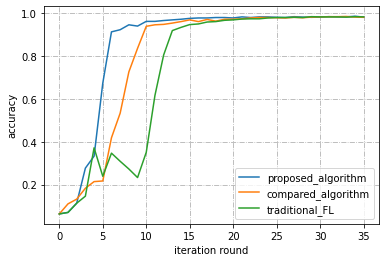

In [31]:
bad_user_number=0
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()

with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))

for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)

global_sess.run(tf.global_variables_initializer())

_,_,validate_global_model_accuracy_0_P=proposed_algorithm_2()
plot_compare_algoritms(validate_global_model_accuracy_0_P,"proposed_algorithm",validate_global_model_accuracy_0_C,"compared_algorithm",validate_global_model_accuracy_0_TFL,"traditional_FL","haha.pdf")

### bad_number=1 & traditinal_FL

In [32]:
bad_user_number=1
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()


with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
validate_global_model_accuracy_1_TFL=traditional_FL()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
0:  0.06899999994784595
1:  0.11200000010430812
2:  0.18599999845027926
3:  0.14000000208616256
4:  0.1989999994635582
5:  0.19699999839067459
6:  0.2389999985694885
7:  0.2540000036358833
8:  0.26500000208616253
9:  0.2889999985694885
10:  0.4800000011920929
11:  0.7019999980926515
12:  0.7949999928474425
13:  0.8860000073909758
14:  0.8950000047683715
15:  0.9099999964237212
16:  0.91599999666214
17:  0.9320000112056733
18:  0.939000004529953
19:  0.948000007867813
20:  0.9530000030994414
21:  0.9550000011920929
22:  0.9619999945163726
23:  0.9609999954700469
24:  0.9649999976158142
25:  0.9669999957084655
26:  0.9659999907016754
27:  0.9679999947547911
28:  0.9730000019073486
29:  0.9719999969005584
30:  0.9709999978542326
31:  0.9709999978542326
32:  0.9719999969005584
33:  0.9729999959468841
34:  0.9710000038146972


### 对比算法 1

In [33]:
bad_user_number=1
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()

with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=False))

for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=False,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)
 
global_sess.run(tf.global_variables_initializer())
number_of_committee_member=int(np.ceil(all_user_number/3))
np.random.seed(0)

# for user_FL in all_user_FL:
#   print(user_FL)
listed_initial_committee_member=np.random.choice(all_user_FL,number_of_committee_member,replace=False)
for i in range(number_of_committee_member):
  listed_initial_committee_member[i].isCommittee=True
# print(listed_initial_committee_member)  
validate_global_model_accuracy_1_C=compared_algorithm()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
all_user_FL_scores[0.09999999925494192, 0.09999999975164733, -1, 0.09999999975164732, -1, 0.10000000024835268, 0.09999999962747097, 0.10000000012417636, 0.10000000080714626, -1, -1]
all_user_FL_scores[0.09999999956538283, 0.09999999993791182, -1, 0.10000000080714622, -1, 0.1000000001862645, 0.09999999975164732, 0.09999999944120644, 0.10000000049670535, -1, -1]
all_user_FL_scores[0.10000000037252903, 0.09999999937911831, -1, 0.10000000037252903, -1, 0.09999999950329462, 0.09999999968955911, 0.10000000024835269, 0.10000000086923441, -1, -1]
all_user_FL_scores[0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0]
[ 0.1  0.1 -1.   0.1 -1.   0.1  0.1  0.1  0.1 -1.  -1. ]
0.09999999941016238
1---------------------ok
3---------------------ok
5---------------------ok
6---------------------ok
[ 0.03208909  0.04994386 -0.05289585  0.03781055  0.00913665]
0:  0.10999999940395357
all_user_FL_scores[0.09999999937911827, -1, 0.0999999

### bad_number=1 & proposed_algorithm

accuracy of pretrain:0.10999999940395355
0.06300000008195639
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
bad_u0
all_user_FL_scores_0: [0.09999999957159161, 0.0999999997454385, 0.09999999977027377, 0.09999999990686774, 0.09999999988203248, 0.10000000008071461, 0.09999999973922967, 0.09999999984477957, 0.09999999993791184, 0.09999999986961484, 0.09999999957159161]
[ 0.02967653  0.04538034 -0.04801352  0.03407268  0.00823199]
0:  0.06899999994784595
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
bad_u0
[ 0.03462748  0.05042161 -0.03770312  0.03575244  0.01349361]
1:  0.11200000010430812
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
bad_u0
[ 0.03569465  0.05054573 -0.03048999  0.03647642  0.01705875]
2:  0.19499999880790708
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
bad_u0
[ 0.03423077  0.05390076 -0.03546537  0.04372052  0.02260988]
3:  0.19200000092387198
u0
[ 0.03628664  0.06079398 -0.04121123  0.04908768  0.02583846]
4:  0.28700000196695324
u0
u1
u2
u4
u6
u7
u8
u9
[ 0.03367492  0.06182002 -0.04969805  0.05167323  0.02170082]
5:  0.5150000005960

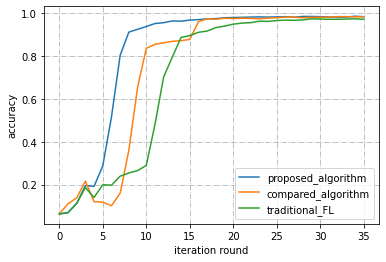

In [34]:
bad_user_number=1
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()



with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
_,_,validate_global_model_accuracy_1_P=proposed_algorithm_2()
plot_compare_algoritms(validate_global_model_accuracy_1_P,"proposed_algorithm",validate_global_model_accuracy_1_C,"compared_algorithm",validate_global_model_accuracy_1_TFL,"traditional_FL","haha.pdf")

### bad_number=2 & traditinal_FL

In [35]:
bad_user_number=2
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()


with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
validate_global_model_accuracy_2_TFL=traditional_FL()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
0:  0.07099999990314246
1:  0.10999999977648257
2:  0.10500000156462193
3:  0.10099999979138374
4:  0.10099999979138374
5:  0.10099999979138374
6:  0.10099999979138374
7:  0.10099999979138374
8:  0.10099999979138374
9:  0.10200000032782554
10:  0.11000000070780513
11:  0.1840000011026859
12:  0.2900000035762787
13:  0.40199999511241913
14:  0.5150000065565109
15:  0.7109999895095824
16:  0.7719999969005584
17:  0.773000007867813
18:  0.7969999969005586
19:  0.8079999923706056
20:  0.852999997138977
21:  0.8699999988079071
22:  0.8719999969005584
23:  0.8720000028610231
24:  0.8850000023841859
25:  0.8910000026226044
26:  0.8839999973773957
27:  0.8750000059604645
28:  0.8790000081062318
29:  0.8930000066757202
30:  0.8810000002384185
31:  0.8830000042915345
32:  0.8970000088214873
33:  0.8970000028610229
34:  0.9010000109672546


### 对比算法 2

In [36]:
bad_user_number=2
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()

with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=False))

for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=False,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)
 
global_sess.run(tf.global_variables_initializer())
number_of_committee_member=int(np.ceil(all_user_number/3))
np.random.seed(0)

# for user_FL in all_user_FL:
#   print(user_FL)
listed_initial_committee_member=np.random.choice(all_user_FL,number_of_committee_member,replace=False)
for i in range(number_of_committee_member):
  listed_initial_committee_member[i].isCommittee=True
# print(listed_initial_committee_member)  
validate_global_model_accuracy_2_C=compared_algorithm()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
all_user_FL_scores[0.09999999956538283, 0.09999999993791182, 0.09999999962747098, 0.10000000080714622, -1, 0.1000000001862645, -1, 0.09999999944120644, 0.10000000049670535, 0.10000000049670536, -1, -1]
all_user_FL_scores[0.09999999975164732, 0.09999999987582366, 0.09999999975164732, 0.10000000024835269, -1, 0.10000000074505806, -1, 0.09999999950329463, 0.10000000055879354, 0.1000000010554989, -1, -1]
all_user_FL_scores[0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, -1.0]
all_user_FL_scores[0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, -1.0]
[ 0.05  0.05  0.05  0.05 -1.    0.05 -1.    0.05  0.05  0.05 -1.   -1.  ]
0.04999999972060322
0---------------------ok
1---------------------ok
2---------------------ok
3---------------------ok
[ 0.03256492  0.05009155 -0.05288816  0.03768307  0.00924487]
0:  0.10499999932944776
all_user_FL_scores[-1, -1, -1, -1, 0.09999999981373547, 0.10000000024835269, 0.1086666655

### bad_number=2 & proposed_algorithm

accuracy of pretrain:0.10999999940395355
0.06300000008195639
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
bad_u0
bad_u1
all_user_FL_scores_0: [0.09999999957159161, 0.0999999997454385, 0.09999999977027377, 0.09999999990686774, 0.09999999988203248, 0.10000000008071461, 0.09999999973922967, 0.09999999984477957, 0.09999999993791184, 0.09999999986961484, 0.09999999957159161, 0.09999999957159161]
[ 0.02720349  0.04159866 -0.04401238  0.0312333   0.00754597]
0:  0.07099999990314246
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
bad_u0
bad_u1
[ 0.02997798  0.0433851  -0.03081992  0.03068096  0.01218617]
1:  0.10999999977648257
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
bad_u0
bad_u1
[ 0.029548    0.04092498 -0.02126425  0.02995891  0.01518861]
2:  0.10500000156462193
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
bad_u0
bad_u1
[ 0.0315739   0.04820238 -0.01972163  0.03701361  0.02535691]
3:  0.19199999943375587
u0
[ 0.03095268  0.05133101 -0.02594019  0.04029424  0.02963366]
4:  0.20399999916553496
u0
u1
u3
u4
u6
u7
u8
u9
[ 0.03030039  0.05645187 -0.0355

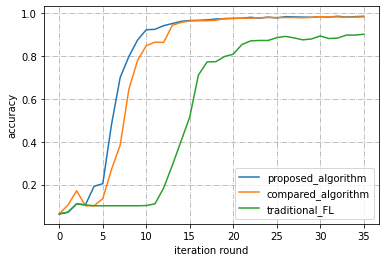

In [37]:
bad_user_number=2
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()



with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
_,_,validate_global_model_accuracy_2_P=proposed_algorithm_2()
plot_compare_algoritms(validate_global_model_accuracy_2_P,"proposed_algorithm",validate_global_model_accuracy_2_C,"compared_algorithm",validate_global_model_accuracy_2_TFL,"traditional_FL","haha.pdf")

### bad_number=3 & traditinal_FL

In [38]:
bad_user_number=3
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()


with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
validate_global_model_accuracy_3_TFL=traditional_FL()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
0:  0.06999999973922967
1:  0.1060000019147992
2:  0.10099999979138374
3:  0.10099999979138374
4:  0.10099999979138374
5:  0.10099999979138374
6:  0.10099999979138374
7:  0.10099999979138374
8:  0.10099999979138374
9:  0.10099999979138374
10:  0.10099999979138374
11:  0.10099999979138374
12:  0.10099999979138374
13:  0.10099999979138374
14:  0.10099999979138374
15:  0.10099999979138374
16:  0.10099999979138374
17:  0.10099999979138374
18:  0.136999998986721
19:  0.19100000038743017
20:  0.19400000050663946
21:  0.21800000220537183
22:  0.25500000417232516
23:  0.28100000470876696
24:  0.32299999743700025
25:  0.49699999690055846
26:  0.6589999973773956
27:  0.7220000088214874
28:  0.7460000097751618
29:  0.7580000042915346
30:  0.7740000069141387
31:  0.7850000023841858
32:  0.7909999907016754
33:  0.793999993801117
34:  0.788999992609024


### 对比算法 3

In [27]:
bad_user_number=3
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()

with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=False))

for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=False,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)
 
global_sess.run(tf.global_variables_initializer())
number_of_committee_member=int(np.ceil(all_user_number/2))
np.random.seed(0)

# for user_FL in all_user_FL:
#   print(user_FL)
listed_initial_committee_member=np.random.choice(all_user_FL,number_of_committee_member,replace=False)
for i in range(number_of_committee_member):
  listed_initial_committee_member[i].isCommittee=True
# print(listed_initial_committee_member)  
validate_global_model_accuracy_3_C=compared_algorithm()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
all_user_FL_scores[0.09999999937911827, -1, -1, 0.09999999999999999, -1, 0.09999999919285377, -1, 0.10000000031044086, -1, 0.09999999956538279, -1, -1, 0.09999999937911827]
all_user_FL_scores[0.09999999925494192, -1, -1, 0.09999999975164732, -1, 0.10000000024835268, -1, 0.10000000012417636, -1, 0.09999999950329459, -1, -1, 0.09999999925494192]
all_user_FL_scores[0.09999999956538283, -1, -1, 0.10000000080714622, -1, 0.1000000001862645, -1, 0.09999999944120644, -1, 0.10000000049670536, -1, -1, 0.09999999956538283]
all_user_FL_scores[0.09999999975164732, -1, -1, 0.10000000024835269, -1, 0.10000000074505806, -1, 0.09999999950329463, -1, 0.1000000010554989, -1, -1, 0.09999999975164732]
all_user_FL_scores[0.09999999937911831, -1, -1, 0.09999999894450108, -1, 0.10000000024835266, -1, 0.09999999913076558, -1, 0.09999999950329463, -1, -1, 0.09999999937911831]
all_user_FL_scores[0.0, -1.0, -1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1

### bad_number=3 & proposed_algorithm

accuracy of pretrain:0.10999999940395355
0.06300000008195639
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
bad_u0
bad_u1
bad_u2
all_user_FL_scores_0: [0.09999999957159161, 0.0999999997454385, 0.09999999977027377, 0.09999999990686774, 0.09999999988203248, 0.10000000008071461, 0.09999999973922967, 0.09999999984477957, 0.09999999993791184, 0.09999999986961484, 0.09999999957159161, 0.09999999957159161, 0.09999999957159161]
[ 0.02511091  0.03839876 -0.04062681  0.02883074  0.00696551]
0:  0.06999999973922967
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
bad_u0
bad_u1
bad_u2
[ 0.02631677  0.03777579 -0.02557796  0.02664653  0.01110741]
1:  0.1060000019147992
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
bad_u0
bad_u1
bad_u2
[ 0.02488976  0.03377134 -0.01495276  0.02499793  0.01356166]
2:  0.10099999979138374
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
bad_u0
bad_u1
bad_u2
[ 0.02790683  0.03667662 -0.01219487  0.02771344  0.01617527]
3:  0.10099999867379666
u2
u3
u4
u5
u7
u8
u9
[ 0.02984178  0.04025474 -0.00940356  0.0310396   0.01689878]
4:  0.11900000

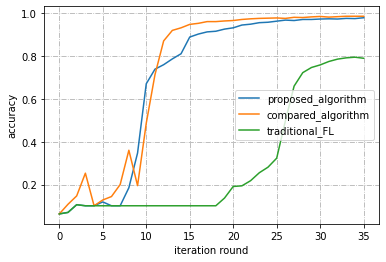

In [40]:
bad_user_number=3
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()



with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
_,_,validate_global_model_accuracy_3_P=proposed_algorithm_2()
plot_compare_algoritms(validate_global_model_accuracy_3_P,"proposed_algorithm",validate_global_model_accuracy_3_C,"compared_algorithm",validate_global_model_accuracy_3_TFL,"traditional_FL","haha.pdf")

### bad_number=4 & traditinal_FL

In [41]:
bad_user_number=4
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()


with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
validate_global_model_accuracy_4_TFL=traditional_FL()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
0:  0.0689999995753169
1:  0.1070000009611249
2:  0.10099999979138374
3:  0.10099999979138374
4:  0.10099999979138374
5:  0.10099999979138374
6:  0.10099999979138374
7:  0.10099999979138374
8:  0.10099999979138374
9:  0.10099999979138374
10:  0.10099999979138374
11:  0.10099999979138374
12:  0.10099999979138374
13:  0.10099999979138374
14:  0.10099999979138374
15:  0.10099999979138374
16:  0.10099999979138374
17:  0.10099999979138374
18:  0.10099999979138374
19:  0.10099999979138374
20:  0.10099999979138374
21:  0.10099999979138374
22:  0.10099999979138374
23:  0.10099999979138374
24:  0.10099999979138374
25:  0.10099999979138374
26:  0.10099999979138374
27:  0.10099999979138374
28:  0.10099999979138374
29:  0.10099999979138374
30:  0.10099999979138374
31:  0.10099999979138374
32:  0.10099999979138374
33:  0.10099999979138374
34:  0.10099999979138374


### 对比算法 4

In [42]:
bad_user_number=4
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()

with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=False))

for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=False,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)
 
global_sess.run(tf.global_variables_initializer())
number_of_committee_member=int(np.ceil(all_user_number/3))
np.random.seed(0)

# for user_FL in all_user_FL:
#   print(user_FL)
listed_initial_committee_member=np.random.choice(all_user_FL,number_of_committee_member,replace=False)
for i in range(number_of_committee_member):
  listed_initial_committee_member[i].isCommittee=True
# print(listed_initial_committee_member)  
validate_global_model_accuracy_4_C=compared_algorithm()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
all_user_FL_scores[0.09999999925494192, 0.09999999975164733, -1, 0.09999999975164732, -1, 0.10000000024835268, -1, 0.10000000012417636, -1, 0.09999999950329459, 0.09999999925494192, -1, 0.09999999925494192, 0.09999999925494192]
all_user_FL_scores[0.09999999956538283, 0.09999999993791182, -1, 0.10000000080714622, -1, 0.1000000001862645, -1, 0.09999999944120644, -1, 0.10000000049670536, 0.09999999956538283, -1, 0.09999999956538283, 0.09999999956538283]
all_user_FL_scores[0.09999999975164732, 0.09999999987582366, -1, 0.10000000024835269, -1, 0.10000000074505806, -1, 0.09999999950329463, -1, 0.1000000010554989, 0.09999999975164732, -1, 0.09999999975164732, 0.09999999975164732]
all_user_FL_scores[0.09999999937911831, 0.10000000068296988, -1, 0.09999999894450108, -1, 0.10000000024835266, -1, 0.09999999913076558, -1, 0.09999999950329463, 0.09999999937911831, -1, 0.09999999937911831, 0.09999999937911831]
all_user_FL_scores[0.0, 0.0, 

### bad_number=4 & proposed_algorithm

accuracy of pretrain:0.10999999940395355
0.06300000008195639
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
bad_u0
bad_u1
bad_u2
bad_u3
all_user_FL_scores_0: [0.09999999957159161, 0.0999999997454385, 0.09999999977027377, 0.09999999990686774, 0.09999999988203248, 0.10000000008071461, 0.09999999973922967, 0.09999999984477957, 0.09999999993791184, 0.09999999986961484, 0.09999999957159161, 0.09999999957159161, 0.09999999957159161, 0.09999999957159161]
[ 0.02331727  0.03565598 -0.03772491  0.02677139  0.00646799]
0:  0.0689999995753169
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
bad_u0
bad_u1
bad_u2
bad_u3
[ 0.02334758  0.03325116 -0.02147135  0.02343981  0.01011134]
1:  0.1070000009611249
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
bad_u0
bad_u1
bad_u2
bad_u3
[ 0.02121892  0.02825441 -0.0106472   0.02120546  0.01208543]
2:  0.10099999979138374
u0
u1
u2
u3
u4
u5
u6
u7
u8
u9
bad_u0
bad_u1
bad_u2
bad_u3
[ 0.0246346   0.03156035 -0.00738161  0.02448974  0.01531353]
3:  0.10099999867379666
u2
u3
u4
u5
u7
u8
u9
[ 0.02742471  0.03552911 -0.

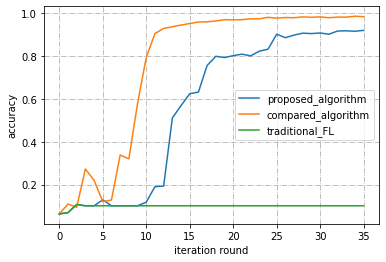

In [43]:
bad_user_number=4
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()



with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
_,_,validate_global_model_accuracy_4_P=proposed_algorithm_2()
plot_compare_algoritms(validate_global_model_accuracy_4_P,"proposed_algorithm",validate_global_model_accuracy_4_C,"compared_algorithm",validate_global_model_accuracy_4_TFL,"traditional_FL","haha.pdf")

### bad_number=5 & traditional_FL

In [44]:
bad_user_number=5
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()


with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,lr=0.0005,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
validate_global_model_accuracy_5_TFL=traditional_FL()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
0:  0.06400000061839818
1:  0.10700000002980233
2:  0.10099999979138374
3:  0.10099999979138374
4:  0.10099999979138374
5:  0.10099999979138374
6:  0.10099999979138374
7:  0.10099999979138374
8:  0.10099999979138374
9:  0.10099999979138374
10:  0.10099999979138374
11:  0.10099999979138374
12:  0.10099999979138374
13:  0.10099999979138374
14:  0.10099999979138374
15:  0.10099999979138374
16:  0.10099999979138374
17:  0.10099999979138374
18:  0.10099999979138374
19:  0.10099999979138374
20:  0.10099999979138374
21:  0.10099999979138374
22:  0.10099999979138374
23:  0.10099999979138374
24:  0.10099999979138374
25:  0.10099999979138374
26:  0.10099999979138374
27:  0.10099999979138374
28:  0.10099999979138374
29:  0.10099999979138374
30:  0.10099999979138374
31:  0.10099999979138374
32:  0.10099999979138374
33:  0.10099999979138374
34:  0.10099999979138374


### 对比算法 5

In [25]:
bad_user_number=5
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()

with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,isCommittee=False))

for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=False,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)
 
global_sess.run(tf.global_variables_initializer())
number_of_committee_member=int(np.ceil(all_user_number/3))
np.random.seed(0)

# for user_FL in all_user_FL:
#   print(user_FL)
listed_initial_committee_member=np.random.choice(all_user_FL,number_of_committee_member,replace=False)
for i in range(number_of_committee_member):
  listed_initial_committee_member[i].isCommittee=True
# print(listed_initial_committee_member)  
validate_global_model_accuracy_5_C=compared_algorithm()

accuracy of pretrain:0.10999999940395355
0.06300000008195639
all_user_FL_scores[0.09999999937911827, -1, 0.09999999962747098, 0.09999999999999999, 0.09999999919285378, 0.09999999919285377, -1, 0.10000000031044086, -1, -1, 0.09999999937911827, 0.09999999937911827, 0.09999999937911827, 0.09999999937911827, -1]
all_user_FL_scores[0.09999999975164732, -1, 0.09999999975164732, 0.10000000024835269, 0.10000000024835268, 0.10000000074505806, -1, 0.09999999950329463, -1, -1, 0.09999999975164732, 0.09999999975164732, 0.09999999975164732, 0.09999999975164732, -1]
all_user_FL_scores[0.09999999937911831, -1, 0.09999999993791185, 0.09999999894450108, 0.09999999993791184, 0.10000000024835266, -1, 0.09999999913076558, -1, -1, 0.09999999937911831, 0.09999999937911831, 0.09999999937911831, 0.09999999937911831, -1]
all_user_FL_scores[0.10000000037252903, -1, 0.09999999981373549, 0.10000000037252903, 0.10000000049670535, 0.09999999950329462, -1, 0.10000000024835269, -1, -1, 0.10000000037252903, 0.10000000

KeyboardInterrupt: ignored

### bad_number=5 & proposed_algorithm

In [ ]:
bad_user_number=5
all_user_number=good_user_number+bad_user_number

tf.reset_default_graph()
global_sess.close()
tf.set_random_seed(2)
global_sess=tf.Session()

with tf.variable_scope("requester"):
  requester_FL=FL("initial_model",global_sess,requester_data,requester_label,isCommittee=True)

all_user_FL=[]
for i in range(good_user_number):
  name="u"+str(i)
  with tf.variable_scope(name):
    data=all_user_data[i]
    label=all_user_label[i]
    user_validate_data=all_user_validate_data[i]
    user_validate_label=all_user_validate_label[i]
    all_user_FL.append(FL(name,global_sess,data,label,user_validate_data,user_validate_label,lr=0.0005,isCommittee=True))


for j in range(bad_user_number):
  name="bad_u"+str(j)
  with tf.variable_scope(name):
    all_user_FL.append(FL(name,global_sess,isCommittee=True,isBad=True))

with tf.variable_scope("global_model"):
  global_model=FL("global_model",global_sess)


global_sess.run(tf.global_variables_initializer())
_,_,validate_global_model_accuracy_5_P=proposed_algorithm_2()

plot_compare_algoritms(validate_global_model_accuracy_5_P,"proposed_algorithm",validate_global_model_accuracy_5_C,"compared_algorithm",validate_global_model_accuracy_5_TFL,"traditional_FL","haha.pdf")


### 保存数据

In [ ]:
Traditional_FL=[validate_global_model_accuracy_0_TFL,validate_global_model_accuracy_1_TFL,validate_global_model_accuracy_2_TFL,validate_global_model_accuracy_3_TFL,validate_global_model_accuracy_4_TFL,validate_global_model_accuracy_5_TFL]
Proposed=[validate_global_model_accuracy_0_P,validate_global_model_accuracy_1_P,validate_global_model_accuracy_2_P,validate_global_model_accuracy_3_P,validate_global_model_accuracy_4_P,validate_global_model_accuracy_5_P]
Compared=[validate_global_model_accuracy_0_C,validate_global_model_accuracy_1_C,validate_global_model_accuracy_2_C,validate_global_model_accuracy_3_C,validate_global_model_accuracy_4_C,validate_global_model_accuracy_5_C]
import pandas as pd
for i in range(6):
  pd.DataFrame(traditional_FL).to_csv("/non_iid/tfl.csv")
  pd.DataFrame(Proposed).to_csv("/non_iid/p.csv")
  pd.DataFrame(Compared).to_csv("/non_iid/c.csv")

### 画图 & 保存原始数据

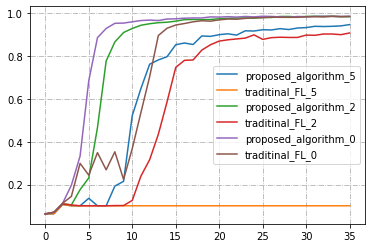

In [ ]:
plt.plot(validate_global_model_accuracy_7,label="proposed_algorithm_5")
plt.plot(validate_global_model_accuracy_8,label="traditinal_FL_5")
plt.plot(validate_global_model_accuracy_3,label="proposed_algorithm_2")
plt.plot(validate_global_model_accuracy_4,label="traditinal_FL_2")
plt.plot(validate_global_model_accuracy_1,label="proposed_algorithm_0")
plt.plot(validate_global_model_accuracy_2,label="traditinal_FL_0")


pd.DataFrame(validate_global_model_accuracy_7).to_csv("/non_iid/proposed_algorithm_5.csv")
pd.DataFrame(validate_global_model_accuracy_8).to_csv("/non_iid/traditinal_FL_5.csv")
pd.DataFrame(validate_global_model_accuracy_3).to_csv("/non_iid/proposed_algorithm_2.csv")
pd.DataFrame(validate_global_model_accuracy_4).to_csv("/non_iid/traditinal_FL_2.csv")
pd.DataFrame(validate_global_model_accuracy_1).to_csv("/non_iid/proposed_algorithm_0.csv")
pd.DataFrame(validate_global_model_accuracy_2).to_csv("/non_iid/traditinal_FL_0.csv")

plt.legend(loc="best")
plt.grid(linestyle='-.')
plt.savefig("bad_model_haha.pdf",format='pdf')  
plt.show()


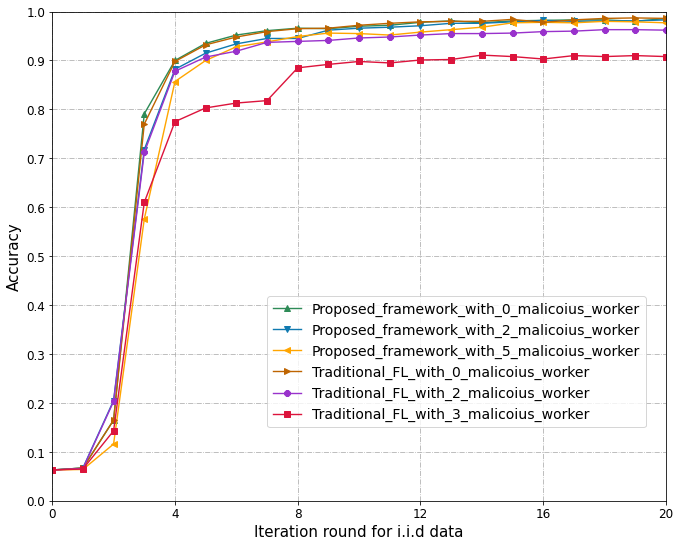

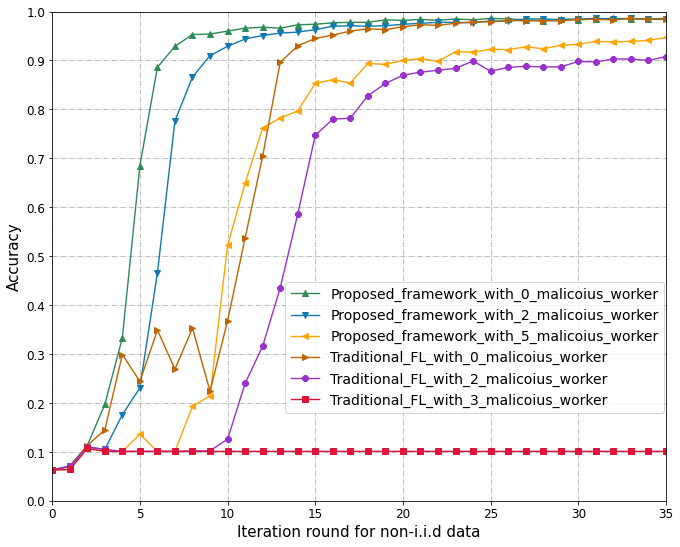

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
iid_value=[]
iid_label=["Proposed_framework_with_0_malicoius_worker",
           "Proposed_framework_with_2_malicoius_worker",          
           "Proposed_framework_with_5_malicoius_worker",
           "Traditional_FL_with_0_malicoius_worker",
           "Traditional_FL_with_2_malicoius_worker",
           "Traditional_FL_with_3_malicoius_worker"]
for i in [0,2,5]:
    iid_value.append(np.reshape(pd.read_csv("/content/drive/MyDrive/EE_blockchain/0.0005_0.05/iid/proposed_algorithm_"+str(i)+".csv",index_col=0).values,[21]))
for i in [0,2,5]:
    iid_value.append(np.reshape(pd.read_csv("/content/drive/MyDrive/EE_blockchain/0.0005_0.05/iid/traditinal_FL_"+str(i)+".csv",index_col=0).values,[21]))
iid_value=np.array(iid_value)

non_iid_value=[]
non_iid_label=["Proposed_framework_with_0_malicoius_worker",
           "Proposed_framework_with_2_malicoius_worker",          
           "Proposed_framework_with_5_malicoius_worker",
           "Traditional_FL_with_0_malicoius_worker",
           "Traditional_FL_with_2_malicoius_worker",
           "Traditional_FL_with_3_malicoius_worker"]
for i in [0,2,5]:
    non_iid_value.append(np.reshape(pd.read_csv("/content/drive/MyDrive/EE_blockchain/0.0005_0.05/non_iid/proposed_algorithm_"+str(i)+".csv",index_col=0).values,[36]))
for i in [0,2,5]:
    non_iid_value.append(np.reshape(pd.read_csv("/content/drive/MyDrive/EE_blockchain/0.0005_0.05/non_iid/traditinal_FL_"+str(i)+".csv",index_col=0).values,[36]))
iid_value=np.array(iid_value)


color=['#2E8B57','#107ab0','orange','#be6400',"darkorchid","crimson"]
markers=["^","v","<",">","8","s"]
def plot_comparaed_figure(n,value,label,xlabel,ylabel,name,data_type=0):
    figsize = 11,9
    figure, ax = plt.subplots(figsize=figsize)
    for i in range(n):
        plt.plot(np.arange(0,len(value[i])),value[i],c=color[i],marker=markers[i],label=label[i],linewidth=1.4)
    plt.yticks(np.linspace(0,1,11),fontsize=12)
    plt.ylim([0,1])
    plt.ylabel(ylabel,fontsize=15)
    plt.xlabel(xlabel,fontsize=15)
    plt.grid(linestyle='-.')  
    if data_type==0:
        plt.xticks(np.linspace(0,20,6),fontsize=12)
        plt.xlim([0,20])
        plt.legend(loc=[0.35,0.15],fontsize=14)
        plt.savefig("iid_acc.pdf")
        
    if data_type==1:
        plt.xticks(np.linspace(0,35,8),fontsize=12)
        plt.xlim([0,35])
        plt.legend(loc=[0.38,0.18],fontsize=14)
        plt.savefig("non_iid_acc.pdf")
   
    
    plt.show()
plot_comparaed_figure(6, iid_value, iid_label, "Iteration round for i.i.d data", "Accuracy", "oo",0)
plot_comparaed_figure(6, non_iid_value, non_iid_label, "Iteration round for non-i.i.d data", "Accuracy", "oo",1)